# Transfer Learning with TensorFlow Hub for TFLite

## Setup

In [38]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.15.0
• Using TensorFlow Hub Version:  0.16.1
• GPU Device Found.


## Select the Hub/TF2 Modeule to Use

In [39]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data Preprocessing

In [40]:
(train_examples, validation_examples, test_examples), info = tfds.load('cats_vs_dogs',
                                                                       with_info=True,
                                                                       as_supervised=True,
                                                                       split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'])

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

## Format the Data

In [41]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return image, label

In [42]:
# Shuffle and batch the data
BATCH_SIZE = 32 #@param {type:"integer"}

In [43]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

In [44]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])

## Defining the Model

In [45]:
do_fine_tuning = False #@param {type:"boolean"}

In [46]:
# Load TFHub Module
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [47]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [48]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 10 #@param {type:"slider", min:1, max:50, step:1}

if do_fine_tuning:
  feature_extractor.trainable = True

  for layer in model.layers[-NUM_LAYERS:]:
    layer.trainable = True

else:
  feature_extractor.trainable = False

## Train the Model

In [49]:
if do_fine_tuning:
  model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                loss=tf.keras.losses.sparse_categorical_crossentropy(),
                metrics=['accuracy'])

else:
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [50]:
EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 41s 53ms/step - loss: 0.0562 - accuracy: 0.9800 - val_loss: 0.0398 - val_accuracy: 0.9867
Epoch 2/5
582/582 [==============================] - 38s 56ms/step - loss: 0.0306 - accuracy: 0.9893 - val_loss: 0.0387 - val_accuracy: 0.9884
Epoch 3/5
582/582 [==============================] - 38s 56ms/step - loss: 0.0254 - accuracy: 0.9908 - val_loss: 0.0407 - val_accuracy: 0.9854
Epoch 4/5
582/582 [==============================] - 37s 55ms/step - loss: 0.0216 - accuracy: 0.9921 - val_loss: 0.0422 - val_accuracy: 0.9871
Epoch 5/5
582/582 [==============================] - 37s 54ms/step - loss: 0.0200 - accuracy: 0.9932 - val_loss: 0.0425 - val_accuracy: 0.9867


## Export the Model

In [51]:
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"

In [52]:
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

In [53]:
%%bash -s $CATS_VS_DOGS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_1_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_1_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2024-05-07 05:12:30.520584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 05:12:30.520644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 05:12:30.538371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 05:12:32.498039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [54]:
loaded = tf.saved_model.load(CATS_VS_DOGS_SAVED_MODEL)

In [55]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_1_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_1_input')})
{'dense_1': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense_1')}


## Convert Using TFLite's Converter

In [56]:
# Load the TFLiteConverter with the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

## Post-Training Quantization

In [57]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

## Post-Training Quantization

In [58]:
def representative_data_gen():
  for input_value, _ in test_batches.take(100):
    yield [input_value]

In [59]:
converter.representative_dataset = representative_data_gen

## Full Interger Quantization

In [60]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

## Finally convert the model

In [61]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

## Test the TFLite Model Using the Python Interpreter

In [62]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [63]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))

  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

100%|██████████| 10/10 [00:00<00:00, 39.26it/s]


In [66]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

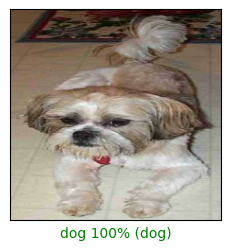

In [85]:
#@title Visualize the outputs { run: "auto" }
index = 2 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

In [68]:
labels = ['cat', 'dog']

with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))

In [69]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Prepare the Test Images for Download (Optional)

In [70]:
!mkdir -p test_images

In [ ]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [71]:
!ls test_images

In [72]:
!zip -qq cats_vs_dogs_test_images.zip -r test_images/

In [73]:
try:
    files.download('cats_vs_dogs_test_images.zip')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>